# <font color=blue>_Visualizing 2016 Campaign Finance in R_.</font>

## Research Question - Did Trump's Base Finance his 2016 Campaign?
Since we have data from individuals that contributed to political campaigns from the FEC, we can look at contributions in 2015-2016 to determine if Trump's base supported his campaign.  Let's follow three steps:
__Step 1__: Gather and consolidate necessary data
__Step 2__: Plot high dimensional data to find patterns
__Step 3__: Plot geospatial data

## <font color=blue>Step 1: Identify relevant variables and merge datasets using Regular Expressions</font>

First let's clean and consolidate the data we need from a number of different sources.  To get started in R, we'll load the necessary packages.

In [54]:
# packages for reading/reshaping data
library(foreign)
library(readr)
library(dplyr)
library(plyr)
library(reshape)

# packages for plotting data
library(ggplot2)
library(lattice)
library(corrplot)
library(GGally)
library(plotly)
library(scatterplot3d)
library(maps) 

### <font color=purple>FEC data - contributions</font>
The FEC provides data on campaign finance here: https://www.fec.gov/data/browse-data/?tab=bulk-data.  Next, we'll import and clean the FEC dataset for 2015-2016.  Since the FEC data seems to be entered by individual donors, it is full of formatting errors.  

In [6]:
# import the fec campaign finance dataset for 2015-2016
cont <- read.dta("contributions2015_2016.dta")

# select specific variables
cont <- subset(cont, select=c("ZIP_CODE", "STATE", "TRANSACTION_AMT", "EMPLOYER", "CMTE_NM", "CMTE_PTY_AFFILIATION"))
names(cont) <- c("zip", "state", "contribution_total", "employer", "campaign", "party")
dim(cont) # counts rows and columns
head(cont) # retrieves first few rows

[1] 20340329        6

,zip,state,contribution_total,employer,campaign,party
,<fct>,<fct>,<int>,<fct>,<fct>,<fct>
1,20837,MD,500,RETIRED,MARY THOMAS FOR CONGRESS,REP
2,32408,FL,1054,SELF,MARY THOMAS FOR CONGRESS,REP
3,337722012,FL,2500,,ERIC LYNN FOR CONGRESS,DEM
4,201911342,VA,50,N/A,VAN HOLLEN FOR SENATE,
5,20003,DC,15158,,MICHIGAN DEMOCRATIC STATE CENTRAL COMMITEE,DEM
6,69361,NE,264,BLUE CROSS BLUE SHIELD OF NE,BLUE CROSS AND BLUE SHIELD OF NEBRASKA PAC,


We will use the zip codes to join and geo-code the dataset.  Here, we fix the formatting of the zipcodes and remove incorrect ones.  Note the use of regular expressions to remove zip codes with punctuation and alpha characters.

In [21]:
# fix zip code to only 5 digits
class(cont$zip)
cont$zip <- as.character(cont$zip)
cont$zip <- trimws(cont$zip)  #removes leading and trailing blank spaces
cont$zip <- substr(cont$zip, start=1, stop=5) # limits zip codes to first 5 characters
cont <- subset(cont, nchar(cont$zip)==5)
cont <- subset(cont, !is.na(cont$zip))
cont <- subset(cont, cont$zip!="")
cont <- subset(cont, cont$zip!="00000")
cont <- subset(cont, cont$zip!="99999")
cont <- subset(cont, grepl("[A-Za-z]", cont$zip)==FALSE) #regex removes zips with letters
cont <- subset(cont, grepl("[:punct:]", cont$zip)==FALSE) #reges removes zips w/ punctuation

# create a data frame of unique 5-digit zip codes
cont_zip <- as.data.frame(table(cont$zip))
cont_zip <- cont_zip[order(-cont_zip$Freq),]
names(cont_zip) <- c("zip", "freq")
head(cont_zip) # preview the data

[1] "character"

,zip,freq
,<fct>,<int>
7529,20001,146394
8341,22042,92715
8399,22202,83449
7249,19130,58890
3582,10025,46707
3580,10023,46284


In this step we aggregate total contributions by zip code and add these values to the unique zip code data frame

In [44]:
# create contribution variables by party and trump
cont$trump <- grepl("trump", cont$campaign, ignore.case = TRUE)
cont$contribution_trump <- ifelse(cont$trump==TRUE, cont$contribution_total, 0)
cont$contribution_dem <- ifelse(cont$party=="DEM", cont$contribution_total, 0)
cont$contribution_rep <- ifelse(cont$party=="REP", cont$contribution_total, 0)
cont$contribution_unk <- ifelse(cont$party=="", cont$contribution_total, 0)

# aggregate contribution variables by zipcode
cont_tot <- subset(camp_fin, select=c("contribution_total", "contribution_rep",
                                      "contribution_dem","contribution_unk", 
                                      "contribution_trump", "zip"))
cont_tot <- as.data.frame(aggregate(. ~ zip, data=cont_tot, FUN=sum))


# merge the data using left outer joins (recall SQL Primer)
cont_zip <- join(cont_zip, cont_tot, by="zip", type="left", match="all")
rm(cont_tot) # remove data

# remove negative contributions from dataset
cont_zip <- subset(cont_zip, cont_zip$contribution_total>0)

# preview the data
head(cont_zip)

[1] "numeric"

,zip,freq,contribution_total,contribution_dem,contribution_rep,contribution_unk,contribution_trump,state,latitude,longitude,⋯,density,avg_home_value,clinton,trump,won,contribution_total.1,contribution_dem.1,contribution_rep.1,contribution_unk.1,contribution_trump.1
,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<int>,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,7529,146394,68390252,5471069,825131,61923669,71360,DC,38.9122,-77.0177,⋯,NA,NA,90.48%,4.07%,dem,NA,NA,NA,NA,NA
2,8341,92715,4279150,236543,155441,3847773,13130,NJ,38.8635,-77.1939,⋯,353.4,146004,54.99%,41.00%,dem,NA,NA,NA,NA,NA
3,8399,83449,5923502,407471,339700,5103403,26808,VA,38.8565,-77.0592,⋯,NA,NA,49.73%,44.41%,dem,NA,NA,NA,NA,NA
4,7249,58890,10376110,624402,30983,9710739,5350,PA,39.9677,-75.1735,⋯,NA,NA,47.46%,48.18%,rep,NA,NA,NA,NA,NA
5,3582,46707,8533784,3732496,208319,4555243,18177,NH,40.7975,-73.9683,⋯,11.7,79042,46.98%,46.61%,dem,NA,NA,NA,NA,NA
6,3580,46284,21715611,7835889,2089522,11696221,67020,NH,40.7764,-73.9827,⋯,5.6,276469,46.98%,46.61%,dem,NA,NA,NA,NA,NA


There are numerous entry errors in the state variable.  Rather than account for all of them, we can find the most frequently occuring state abbreviation for each zip code. 

In [23]:
# clean formatting of state variable
class(cont$state)
cont$state <- trimws(cont$state)
cont$state <- substr(cont$state, start=1, stop=2)
cont <- subset(cont, cont$state!="AA")
cont <- subset(cont, cont$state!="ZZ")
cont <- subset(cont, cont$state!="")

# create a function to calcuate the most frequenly occuring instance (mode) 
calculate_mode <- function(x){
  uniqx <- unique(na.omit(x))
  uniqx[which.max(tabulate(match(x, uniqx)))]
}

# create a data frame of most frequently occuring state name by zip
states <- subset(cont, select=c("zip", "state")) 
states <- distinct(states)
states <- as.data.frame(with(states, tapply(as.character(state), zip, FUN=calculate_mode)))
states <- data.frame(rownames(states), states)
names(states) <- c("zip", "state")
rm(calculate_mode)

# join data frames
cont_zip <- join(cont_zip, states, by="zip", type="left", match="all")
rm(states)
head(cont_zip)

[1] "character"

,zip,freq,contribution_total,contribution_dem,contribution_rep,contribution_unk,contribution_trump,state
,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,20001,146394,68390252,5471069,825131,61923669,71360,DC
2,22042,92715,4279150,236543,155441,3847773,13130,VA
3,22202,83449,5923502,407471,339700,5103403,26808,VA
4,19130,58890,10376110,624402,30983,9710739,5350,PA
5,10025,46707,8533784,3732496,208319,4555243,18177,NY
6,10023,46284,21715611,7835889,2089522,11696221,67020,NY


### <font color=purple>Geo-location data - latitude and longitude</font>
Now we will join the FEC contributions data with geolocation data for the latitude and longitude of each zip code

In [24]:
# read in the zip code data
zips <- "http://download.geonames.org/export/zip/US.zip"
temp <- tempfile()
download.file(zips, temp)
zips <- read.table(unz(temp, "US.txt"), sep="\t")
unlink(temp)
names(zips) = c("CountryCode", "zip", "PlaceName", 
                   "AdminName1", "AdminCode1", "AdminName2", "AdminCode2", 
                  "AdminName3", "AdminCode3", "latitude", "longitude", "accuracy")
rm(temp)

# subset and join the geolocation data with fec
zips <- subset(zips, select=c("zip", "latitude", "longitude"))
zips <- distinct(zips)
cont_zip <- join(cont_zip, zips, by="zip", type="left", match="all")
rm(zips)

head(cont_zip)

,zip,freq,contribution_total,contribution_dem,contribution_rep,contribution_unk,contribution_trump,state,latitude,longitude
,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,20001,146394,68390252,5471069,825131,61923669,71360,DC,38.9122,-77.0177
2,22042,92715,4279150,236543,155441,3847773,13130,VA,38.8635,-77.1939
3,22202,83449,5923502,407471,339700,5103403,26808,VA,38.8565,-77.0592
4,19130,58890,10376110,624402,30983,9710739,5350,PA,39.9677,-75.1735
5,10025,46707,8533784,3732496,208319,4555243,18177,NY,40.7975,-73.9683
6,10023,46284,21715611,7835889,2089522,11696221,67020,NY,40.7764,-73.9827


### <font color=purple>Population data</font>
Another geolocation dataset that provides latitude, longitude, and population size by zip codes is provided here: https://simplemaps.com/data/us-zips.  In this section we join this dataset with campaign contributions

In [26]:
# read in population data
pop <- read.csv("uszips.csv", header = TRUE)
colnames(pop)

# subset the population data
pop <- subset(pop, select=c("zip", "population", "density", "lat", "long", "state_id" ))
pop <- distinct(pop)
class(pop$zip)
class(cont_zip$zip)
cont_zip$zip <- as.integer(cont_zip$zip)

# merge datasets
cont_zip <- join(cont_zip, pop, by="zip", type="left", match="all")
rm(pop)

# replace missing latitudes and longitudes with ones available in this dataset
cont_zip$latitude <- ifelse(is.na(cont_zip$latitude), cont_zip$lat, cont_zip$latitude)
cont_zip$longitude <- ifelse(is.na(cont_zip$longitude), cont_zip$long, cont_zip$longitude)

# replace state abbreviations with ones in population dataset
cont_zip$state_id <- as.character(cont_zip$state_id)
cont_zip$state <- as.character(cont_zip$state)
cont_zip$state <- ifelse(is.na(cont_zip$state_id), cont_zip$state, 
                         ifelse(cont_zip$state!=cont_zip$state_id, 
                                cont_zip$state_id, cont_zip$state))
cont_zip <- cont_zip[,c(1:12)]
head(cont_zip)

[1] "zip"         "lat"         "long"        "city"        "state_id"   
 [6] "state_name"  "population"  "density"     "county_fips" "county_name"

[1] "integer"

[1] "integer"

,zip,freq,contribution_total,contribution_dem,contribution_rep,contribution_unk,contribution_trump,state,latitude,longitude,population,density
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<dbl>
1,7529,146394,68390252,5471069,825131,61923669,71360,DC,38.9122,-77.0177,NA,NA
2,8341,92715,4279150,236543,155441,3847773,13130,NJ,38.8635,-77.1939,2305,353.4
3,8399,83449,5923502,407471,339700,5103403,26808,VA,38.8565,-77.0592,NA,NA
4,7249,58890,10376110,624402,30983,9710739,5350,PA,39.9677,-75.1735,NA,NA
5,3582,46707,8533784,3732496,208319,4555243,18177,NH,40.7975,-73.9683,2459,11.7
6,3580,46284,21715611,7835889,2089522,11696221,67020,NH,40.7764,-73.9827,1306,5.6


### <font color=purple>Average Home Price data</font>
Zillow provides average home price data by zip codes here: https://www.fhfa.gov/DataTools/Downloads/Pages/House-Price-Index-Datasets.aspx. We can merge average home prices from October 2016 with the campaign contribution data.

In [28]:
# read in the data
homes <- read.csv("Zip_Zhvi_AllHomes.csv", header = TRUE)

# subset to October 2016 averages
homes <- subset(homes, select=c("RegionName", "X2016.10"))
names(homes) <- c("zip", "avg_home_value")

# combine data with FEC
cont_zip$zip <- as.character(cont_zip$zip)
homes$zip <- as.character(homes$zip)
cont_zip <- join(cont_zip, homes, by="zip", type="left", match="all")
rm(homes)
head(cont_zip)

,zip,freq,contribution_total,contribution_dem,contribution_rep,contribution_unk,contribution_trump,state,latitude,longitude,population,density,avg_home_value
,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<int>
1,7529,146394,68390252,5471069,825131,61923669,71360,DC,38.9122,-77.0177,NA,NA,NA
2,8341,92715,4279150,236543,155441,3847773,13130,NJ,38.8635,-77.1939,2305,353.4,146004
3,8399,83449,5923502,407471,339700,5103403,26808,VA,38.8565,-77.0592,NA,NA,NA
4,7249,58890,10376110,624402,30983,9710739,5350,PA,39.9677,-75.1735,NA,NA,NA
5,3582,46707,8533784,3732496,208319,4555243,18177,NH,40.7975,-73.9683,2459,11.7,79042
6,3580,46284,21715611,7835889,2089522,11696221,67020,NH,40.7764,-73.9827,1306,5.6,276469


### <font color=purple>2016 Presidential Election Results data</font>
Finally we combine the campaign contribution data with data on whether Clinton or Trump won each state in 2016

In [30]:
# read in the data
pres <- read.csv("pres2016.csv", header = TRUE)
colnames(pres)

# subset to desired values
pres <- subset(pres, select=c("state_ab", "clinton", "trump", "won"))
names(pres)[1] <- "state"

# clean state abbreviations
class(pres$state)
pres$state <- as.character(pres$state)
pres$state <- trimws(pres$state)
class(cont_zip$state)

# join the data
cont_zip <- join(cont_zip, pres, by="state", type="left", match="all")
rm(pres)

head(cont_zip)

[1] "state"    "state_ab" "clinton"  "trump"    "won"

[1] "factor"

[1] "character"

,zip,freq,contribution_total,contribution_dem,contribution_rep,contribution_unk,contribution_trump,state,latitude,longitude,population,density,avg_home_value,clinton,trump,won
,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<int>,<fct>,<fct>,<fct>
1,7529,146394,68390252,5471069,825131,61923669,71360,DC,38.9122,-77.0177,NA,NA,NA,90.48%,4.07%,dem
2,8341,92715,4279150,236543,155441,3847773,13130,NJ,38.8635,-77.1939,2305,353.4,146004,54.99%,41.00%,dem
3,8399,83449,5923502,407471,339700,5103403,26808,VA,38.8565,-77.0592,NA,NA,NA,49.73%,44.41%,dem
4,7249,58890,10376110,624402,30983,9710739,5350,PA,39.9677,-75.1735,NA,NA,NA,47.46%,48.18%,rep
5,3582,46707,8533784,3732496,208319,4555243,18177,NH,40.7975,-73.9683,2459,11.7,79042,46.98%,46.61%,dem
6,3580,46284,21715611,7835889,2089522,11696221,67020,NH,40.7764,-73.9827,1306,5.6,276469,46.98%,46.61%,dem


Finally we can save the data frame.

In [31]:
#write_excel_csv(cont_zip, "campaign_finance.csv", col_names = TRUE)

## <font color=blue>Step 2: Multivariate Data Plots</font>

Now we can look at different cuts of the data to observe trends.  First, let's read in a cleaned version of the dataset for total 2016 campaign contributions by zip code. 

In [33]:
#import the dataset
camp_fin <- read.csv("campaign_finance.csv")

#inspect
dim(camp_fin) # number of observations and variables
colnames(camp_fin) #variables names
head(camp_fin) # preview data

[1] 27128    15

[1] "zip"                "contribution_total" "contribution_dem"  
 [4] "contribution_rep"   "contribution_unk"   "contribution_trump"
 [7] "state"              "latitude"           "longitude"         
[10] "population"         "density"            "avg_home_value"    
[13] "clinton"            "trump"              "won"

,zip,contribution_total,contribution_dem,contribution_rep,contribution_unk,contribution_trump,state,latitude,longitude,population,density,avg_home_value,clinton,trump,won
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<int>,<dbl>,<int>,<fct>,<fct>,<fct>
1,20001,68390680,5471487,825131,61923679,71360,DC,38.9122,-77.0177,46716,6816.2,638531,90.48%,4.07%,dem
2,22042,4279150,236543,155441,3847773,13130,VA,38.8635,-77.1939,34486,1959.9,492817,49.73%,44.41%,dem
3,22202,5923502,407471,339700,5103403,26808,VA,38.8565,-77.0592,24913,2250.1,621300,49.73%,44.41%,dem
4,19130,10376115,624407,30983,9710739,5350,PA,39.9677,-75.1735,27410,7419.3,343703,47.46%,48.18%,rep
5,10025,8533984,3732696,208319,4555243,18177,NY,40.7975,-73.9683,92805,48594.3,1311902,59.01%,36.52%,dem
6,10023,21717121,7836149,2089522,11697471,67020,NY,40.7764,-73.9827,62435,48060.9,1285622,59.01%,36.52%,dem


In [34]:
# create a dummy variable that is 1 if trump won the 2016 election 
# in that state and 0 otherwise
camp_fin$trumpwon <- ifelse(camp_fin$won=="rep", 1, 0)

### <font color=purple>Correlation Plots</font>
Here we can create a correlation plot for continuous and dummy variables

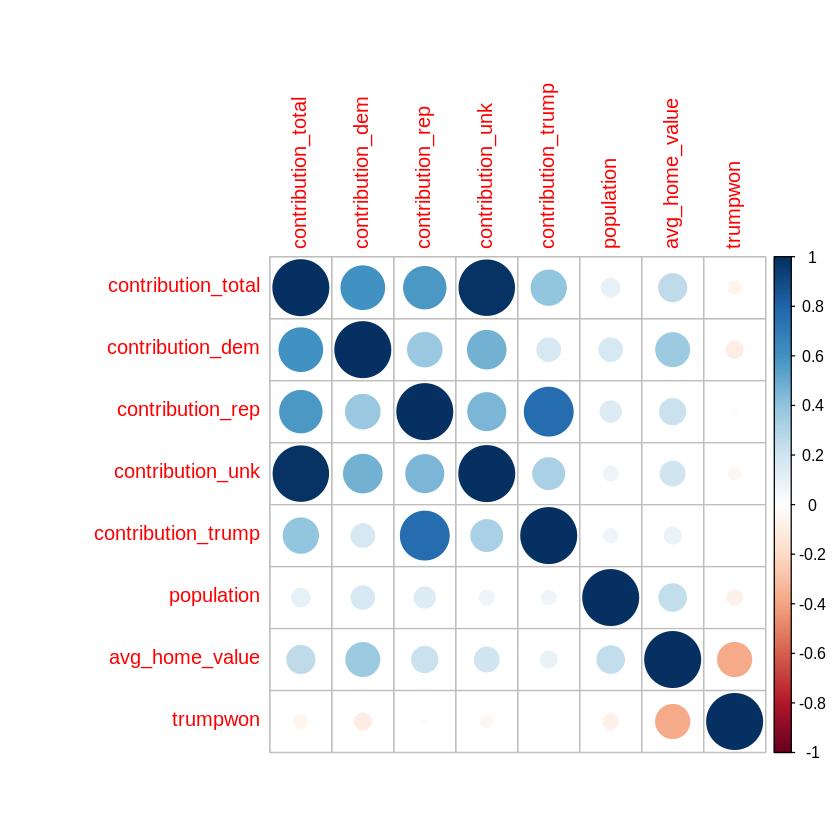

In [38]:
# subset the dataset to only include continuous and dummy variables
camp <- camp_fin[c(2:6,10,12,16)]

# create correlation plot
par(mfrow=c(1,1))
correlations <- cor(camp)
corrplot(correlations, method="circle")

### <font color=purple>Bar Graphs and Scatterplots using ggplot</font>

Now we can use the __ggplot2__ library to make some scatterplots of the data to determine trends.  To start, let's see if there are trends in total campaign donations by state. We can create a variable for Republican contributions going to candidates other than Trump, and plot the data in a bar graph.

In [83]:
# subset contribution data
cont_tot <- subset(camp_fin, select=c("contribution_total", "contribution_rep",
                                      "contribution_dem","contribution_unk", 
                                      "contribution_trump", "state"))
# recode variable
cont_tot$contribution_rep <- cont_tot$contribution_rep - cont_tot$contribution_trump

# aggregate sums at the state level
cont_tot <- as.data.frame(aggregate(. ~ state, data=cont_tot, FUN=sum))

# sort by states that contributed most to campaigns
cont_tot <- cont_tot[order(-cont_tot$contribution_total),]
names(cont_tot) <- c("State", "Total", "Other_Replican", "Democrat", "Unknown", "Trump")
head(cont_tot)

,State,Total,Other_Replican,Democrat,Unknown,Trump
,<fct>,<int>,<int>,<int>,<int>,<int>
5,CA,864466707,67167048,222741644,541512603,24271303
35,NY,685398248,42032460,145564354,457312612,34653808
44,TX,406655784,50950683,46793556,272533254,30362509
8,DC,400856753,12815408,48830852,336603226,431538
10,FL,396896318,59572077,68587843,242390821,22689147
15,IL,305858820,28857045,50984524,213643353,7020088


Then we can reformat the data from wide to long to use in a bar graph for top 10 states that made the most contributions.

,State,Campaign,Amount
,<fct>,<fct>,<int>
11,NY,Other_Replican,42032460
12,TX,Other_Replican,50950683
13,CA,Other_Replican,67167048
14,FL,Other_Replican,59572077
15,IL,Other_Replican,28857045
16,GA,Other_Replican,10767543


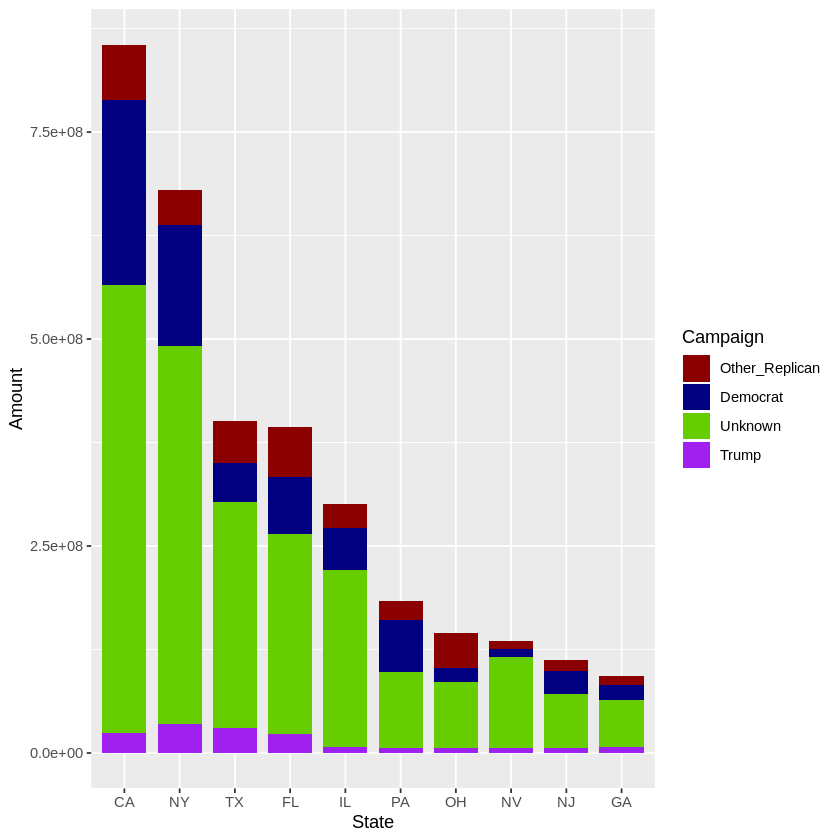

In [92]:
# reformat data from wide to long
cont_tot2 <- cont_tot[1:10,]
cont_tot2 <- melt(cont_tot2, id.vars="State")
names(cont_tot2) <- c("State", "Campaign", "Amount")
cont_tot2 <- subset(cont_tot2, cont_tot2$Campaign!="Total")
head(cont_tot2)

# create a stacked bar graph
par(mfrow=c(1,1))
ggplot(cont_tot2, aes(x=reorder(State, -Amount), y=Amount, fill=Campaign, width=.8)) +
geom_bar(stat="identity") + 
scale_fill_manual(values= c("red4", "navyblue", "chartreuse3", "purple")) +
xlab("State")

Let's plot the Top 10 states for Trump's campaign donations.

,State,Trump
,<fct>,<int>
35,NY,34653808
44,TX,30362509
5,CA,24271303
10,FL,22689147
15,IL,7020088
11,GA,6716578


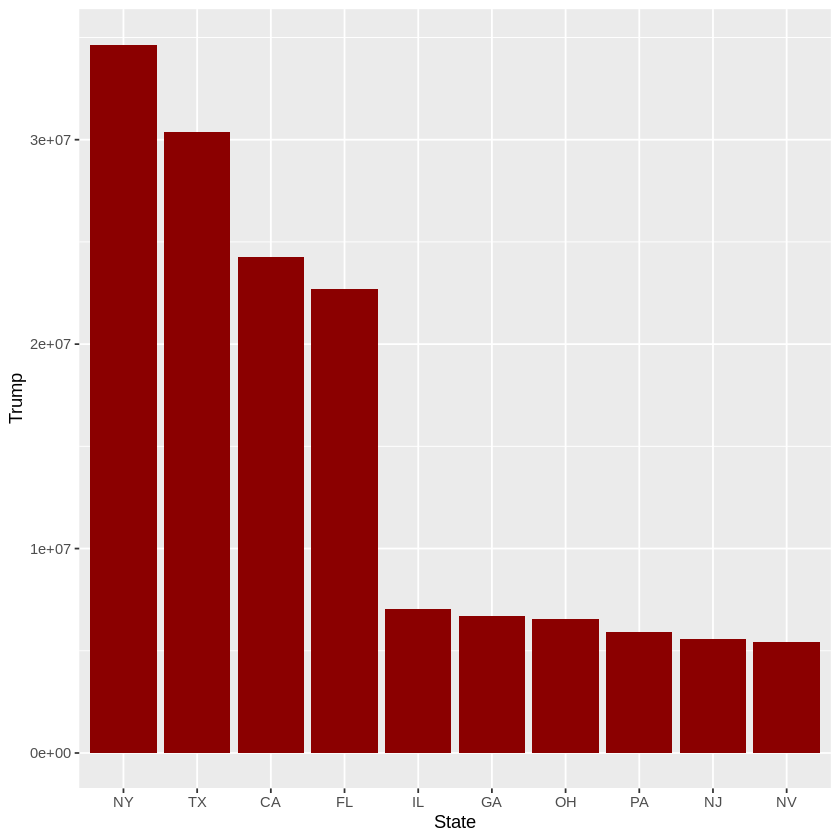

In [91]:
cont_tot <- cont_tot[order(-cont_tot$Trump),]
cont_trump <- subset(cont_tot, select=c("State", "Trump"))
cont_trump <- cont_trump[1:10,]
head(cont_trump)

# create bar graph
par(mfrow=c(1,1))
ggplot(cont_trump, aes(x=reorder(State, -Trump), y=Trump)) + 
geom_bar(stat="identity", fill="red4") + 
xlab("State")

Let's restrict the dataset to the 1,000 zip codes that made the largest campaign donations to Trump in 2015-2016.  We can use a scatterplot to capture four dimensions of the data (1. population size, 2. average home value, 3. campaign contributions to President Trump, and 4. whether Trump or Clinton won the election in that state in 2016.

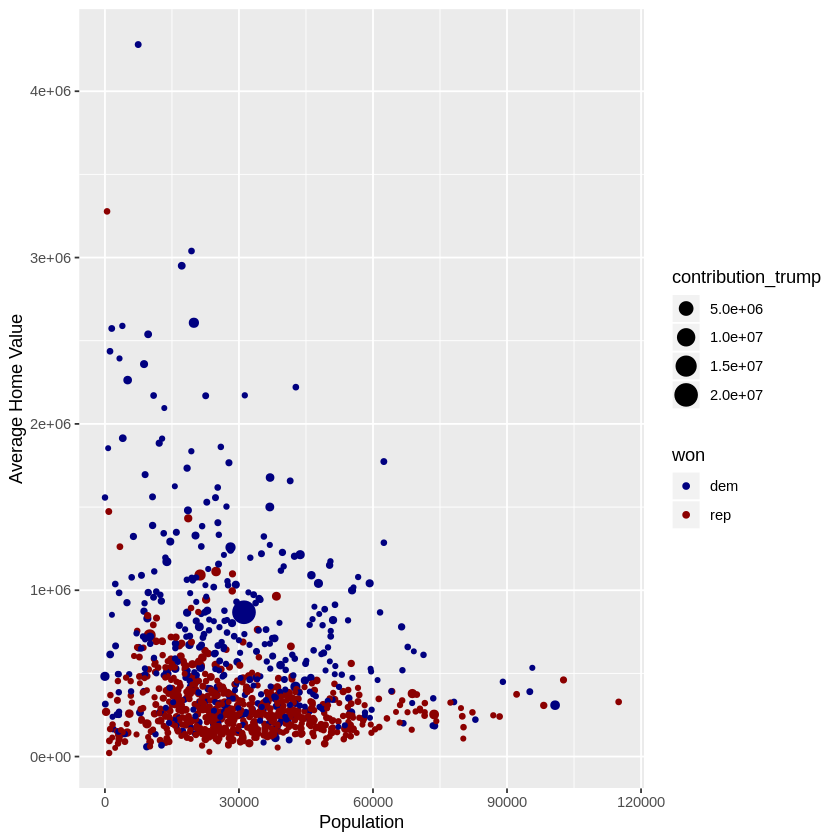

In [100]:
camp_fin <- camp_fin[order(-camp_fin$contribution_trump),]
camp_trump <- camp_fin[1:1000,]

ggplot(camp_trump, aes(population,avg_home_value)) +
geom_point(aes(colour = won, size = contribution_trump)) +
scale_color_manual(values= c("navyblue", "red4")) +
ylab("Average Home Value") + xlab("Population")

We can also use a 3D scatterplot to visualize those same dimensions.

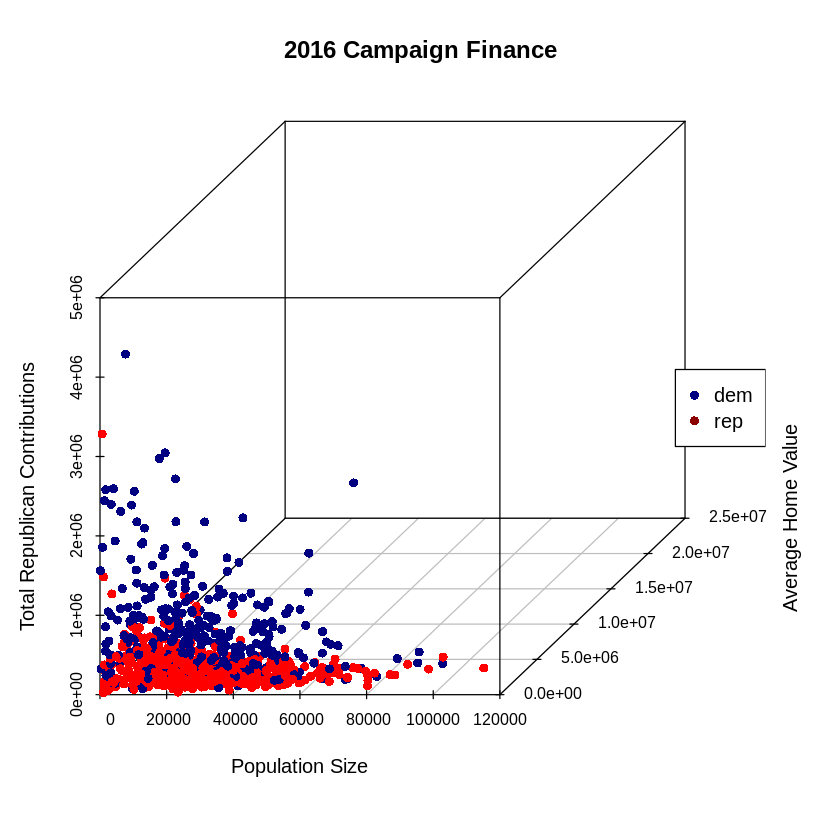

In [101]:
# 3D Plots
colors <- c("navyblue", "red")
scatterplot3d(camp_trump$population, 
              camp_trump$contribution_trump, 
              camp_trump$avg_home_value, 
              main = "2016 Campaign Finance",
              xlab = "Population Size",
              ylab = "Average Home Value",
              zlab = "Total Republican Contributions",
              pch= 16, 
              color=colors[as.numeric(camp_trump$won)])

legend("right", legend = levels(camp_fin$won),
                      col = c("navyblue", "red4"), pch= 16)

#colors <- colors[as.numeric(camp_fin$trumpwon)]
#scatterplot3d(camp_fin[,c(5,10,12)], pch = 16, color=colors)

## <font color=blue>Step 3: Geospatial Maps</font>

Finally we can visit the question of whether Trump's base financed his 2016 campaign. This is possible using the __maps__ library in R.  In the graph below. In the geo-spatial plot below we show the location of the 1000 zipcodes that donated the most to the Trump 2016 campaign.

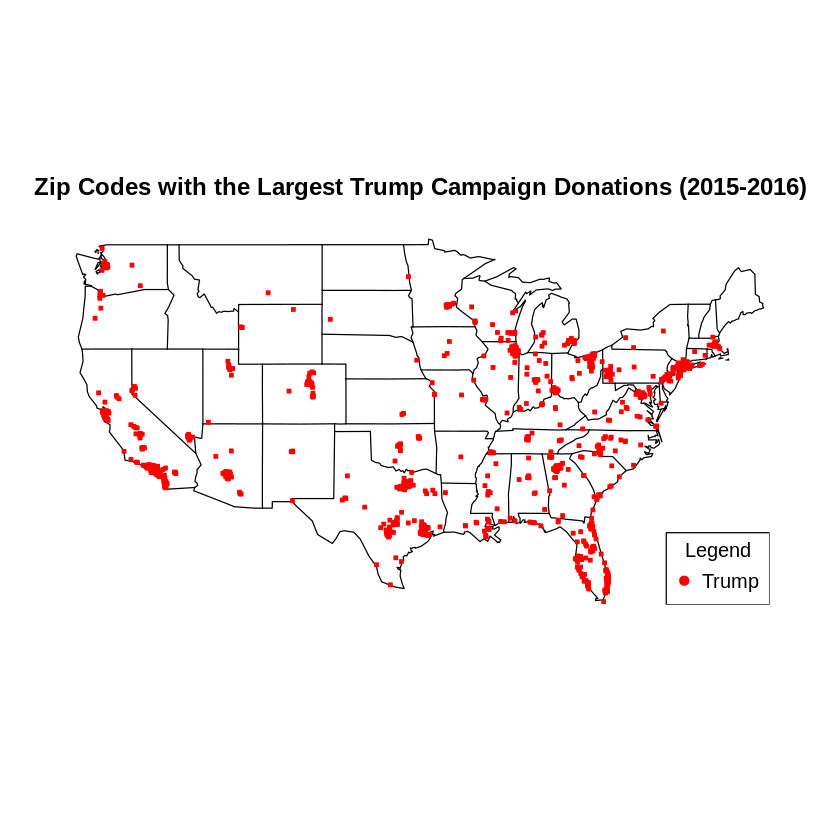

In [128]:
# Geospatial Data
map(database="state")
symbols(camp_trump$longitude, camp_trump$latitude,bg = 'red', fg = 'red', 
        squares =rep(1, length(camp_trump$longitude)), inches=0.03, add=TRUE)
legend("bottomright", legend = c("Trump"), pch = c(19,NA),
       col = "red" , title = "Legend")
title("Zip Codes with the Largest Trump Campaign Donations (2015-2016)")

We can also look specifically at these contributions made in Illinois.  Suprisingly some zip codes near Cook County made sizable aggregate donations to Trumps 2016 election.

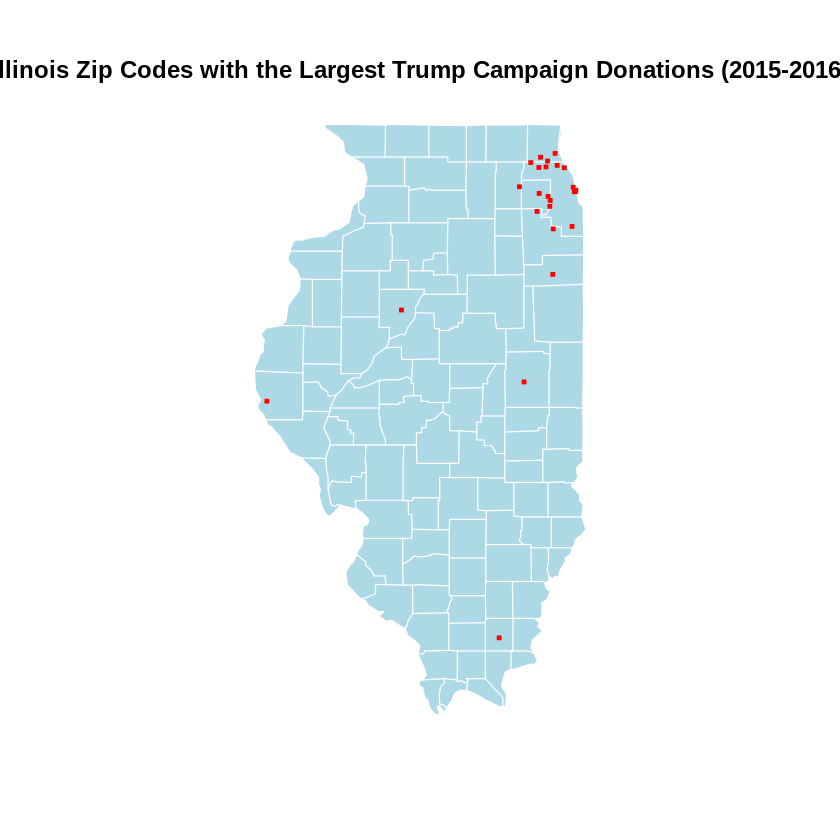

In [115]:
trump_il <- subset(camp_trump, camp_trump$state=="IL")
map(database = 'state', regions = 'Illinois', col = "lightblue", fill = TRUE, border = NA)
map(database = 'county', regions = 'Illinois', col = "white", fill = FALSE, add = TRUE)
symbols(trump_il$longitude, trump_il$latitude,bg = 'red', fg = 'red', 
        squares =rep(1, length(trump_il$longitude)), inches=0.03, add=TRUE)
title("Illinois Zip Codes with the Largest Trump Campaign Donations (2015-2016)")